# Skew data in Spark

## Issues with skew data in processing

- Imbalanced workload: some partitions may have significantly more data than others, lead to some tasks taking much longer to complete, which can slow down the entire job.

- Out of memory errors: skewed data can cause out of memory errors, can be particularly problematic if the data is being cached in memory for iterative processing.

- Uneven resource usage: a partition may consume a disproportionate amount of resources (such as CPU or memory), leading to inefficient resource utilization.

- Slow processing times: Skewed data can cause slower processing times, particularly for operations like joins and aggregations, which require shuffling and data movement between partitions.

- Job failures: skewed partitions cause out-of-memory errors or lead to long-running tasks that exceed the maximum allotted time.

## How to handle skew data?

- Salting: add a random prefix to the key of each record to distribute the data uniformly across the partitions.
- Bucketing: partition data based on the values of a key into a fixed number of buckets.
- Broadcast join:
    - For join operations.
    
    - Broadcast the small table to all the partitions of the large table, reducing the amount of data that needs to be shuffled.

        &rarr; Reduce the impact of skew data.

        
- Co-partitioning:
    - For join operations.
    
    - Partition two tables using the same partitioning scheme to ensure that the data is distributed uniformly across the partitions.

    
- Adaptive Query Execution (Spark >= 3.2.0): Spark SQL that makes use of the runtime statistics to choose the most efficient query execution plan.
    - 2 parameters to enable:
        - `spark.sql.adaptive.enabled`.

        - `spark.sql.adaptive.skewedJoin.enabled`.
        
    - 2 addtional parameters to tune skew join:
        - `spark.sql.adaptive.skewJoin.skewedPartitionFactor`.

        - `spark.sql.adaptive.skewJoin.skewedPartitionThresholdInBytes`. 

## Implementing HashPartitioner and RangePartitioner with skew data

### Data generation (skew keys, uniform values)

In [1]:
import matplotlib.pyplot as plt
import random

In [2]:
data = []
for i in range(50000):

    key = random.randint(0, 400)
    value = random.randint(0, 4000)
    data.append((key, value))

for i in range(50000):

    key = random.randint(0, 100)
    value = random.randint(0, 4000)
    data.append((key, value))

len(data)

100000

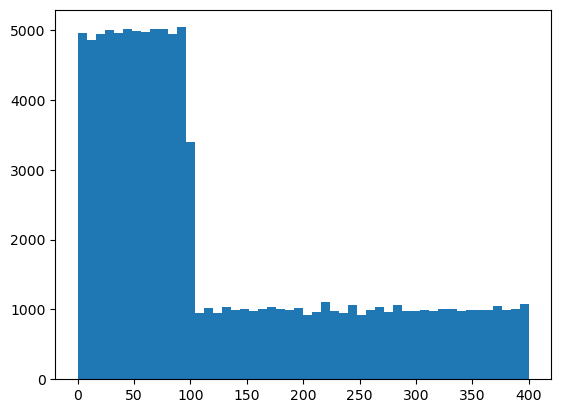

In [3]:
key_list, value_list = [k for k, v in data], [v for k, v in data]
plt.hist(key_list, bins=50)
plt.show()

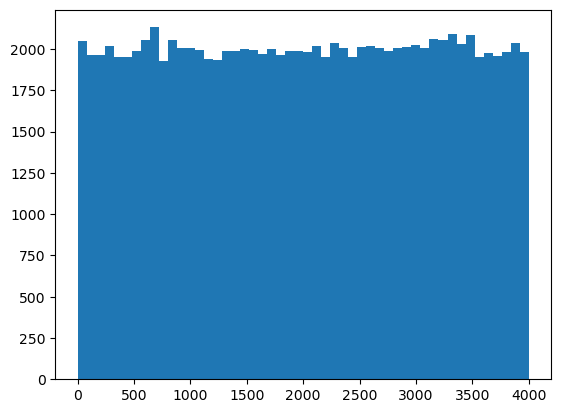

In [4]:
plt.hist(value_list, bins=50)
plt.show()

In [92]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import spark_partition_id, max, col, lag, rand, round, concat, lit
from pyspark.sql.window import Window

In [58]:
spark_session = SparkSession.builder.master('local[*]').appName('Skew Data Test').getOrCreate()
df_data = spark_session.createDataFrame(data, schema=('key integer, value integer'))

### Repartition with column "key"

In [48]:
repartitioned_data = df_data.repartition(12, 'key')

In [49]:
partition_distribution = repartitioned_data.rdd.glom().map(len).collect()

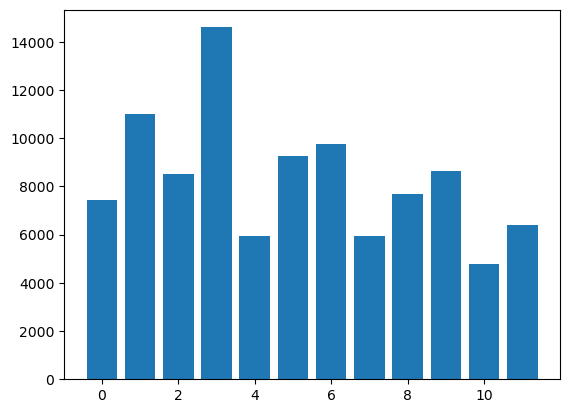

In [50]:
plt.bar(range(12), partition_distribution)
plt.show()

### Repartition with column "value"

In [51]:
repartitioned_data = df_data.repartition(12, 'value')

In [52]:
partition_distribution = repartitioned_data.rdd.glom().map(len).collect()

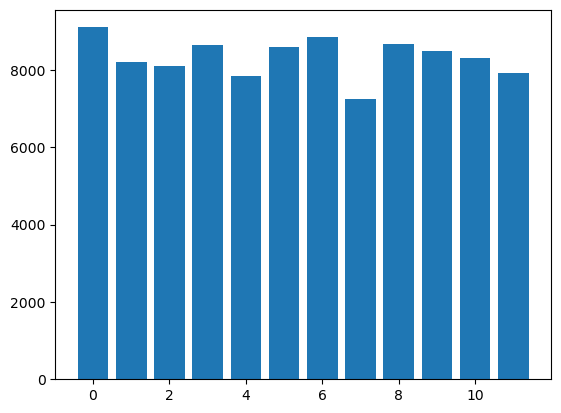

In [53]:
plt.bar(range(12), partition_distribution)
plt.show()

### Making a RangePartitioner

- Take a sample of the original dataset that has quite the same distribution.

- Sort the sample and determine the split points by taking the value at each and every fraction of num_of_partitions.

- Use the split points as the RangePartitioner for the original dataset

In [38]:
repartitioned_data = df_data.repartitionByRange(12, 'key')

In [39]:
partition_distribution = repartitioned_data.rdd.glom().map(len).collect()

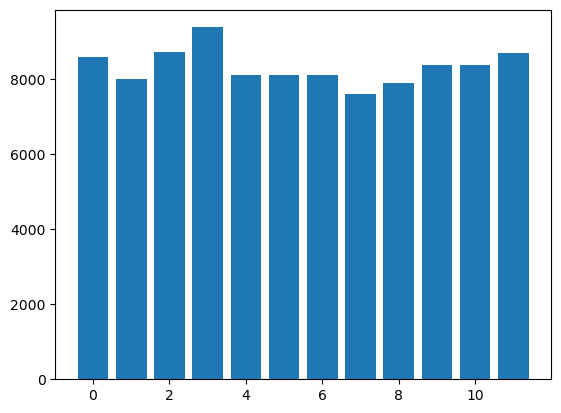

In [40]:
plt.bar(range(12), partition_distribution)
plt.show()

In [55]:
windowSpec  = Window.orderBy('max_key')

repartitioned_data.withColumn('partition_id', spark_partition_id()) \
                  .groupBy('partition_id') \
                  .agg(max('key').alias('max_key')) \
                  .withColumn('difference', col('max_key') - lag('max_key', offset=1).over(windowSpec)) \
                  .show()

+------------+-------+----------+
|partition_id|max_key|difference|
+------------+-------+----------+
|           0|     15|      NULL|
|           1|     29|        14|
|           2|     42|        13|
|           3|     54|        12|
|           4|     67|        13|
|           5|     79|        12|
|           6|     92|        13|
|           7|    133|        41|
|           8|    198|        65|
|           9|    268|        70|
|          10|    335|        67|
|          11|    400|        65|
+------------+-------+----------+



### Custom partitioner in PySpark

- Inspect the dataset to figure out the appropriate partitioning function.
- The function receives the value of `key` in the RDD and outputs the corresponding partition_id.

*Note: Dataset has to be RDD(key, value)*

In [64]:
rdd_data = df_data.rdd.map(lambda row: (row[0], row[1]))

In [65]:
def custom_hash_partitioner(key):
    num_of_partitions = 12
    return key % num_of_partitions

In [66]:
repartitioned_data = rdd_data.partitionBy(12, custom_hash_partitioner)

In [69]:
partition_distribution = repartitioned_data.glom().map(len).collect()

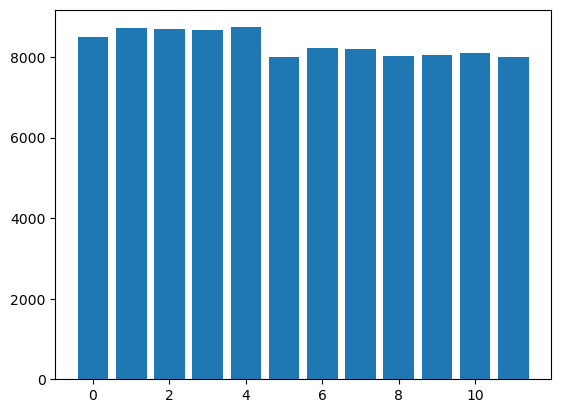

In [70]:
plt.bar(range(12), partition_distribution)
plt.show()

In [76]:
rdd_data = df_data.rdd.map(lambda row: (row[0], row[1]))

In [77]:
def custom_range_partitioner(key):
    min_key_value = 0
    max_key_value = 400
    num_of_partitions = 12

    for i in range(num_of_partitions):
        threshold = (max_key_value - min_key_value) * (i + 1) ** 2 / num_of_partitions ** 2
        if key <= threshold: 
            return i

In [78]:
repartitioned_data = rdd_data.partitionBy(12, custom_range_partitioner)

In [79]:
partition_distribution = repartitioned_data.glom().map(len).collect()

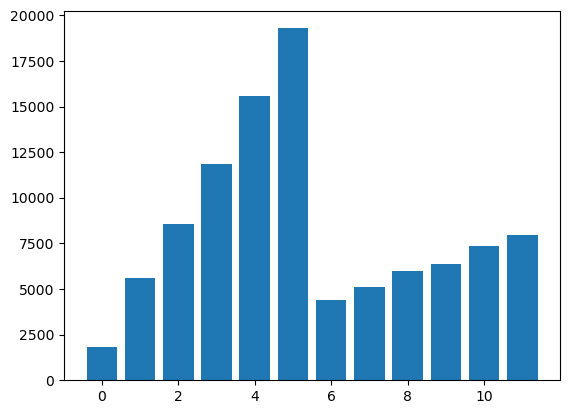

In [80]:
plt.bar(range(12), partition_distribution)
plt.show()

### Salting to handle skew data

- Create a new column that has a random value as a prefix of the skew column.
- Repartition on that column.

In [93]:
salted_df_data = df_data.withColumn('salt', round(rand(seed=42) * 100)) \
                        .withColumn('salted_key', concat(col('salt'), lit('_'), col('key')))

In [94]:
repartitioned_data = salted_df_data.repartition(12, 'salted_key')

In [95]:
partition_distribution = repartitioned_data.rdd.glom().map(len).collect()

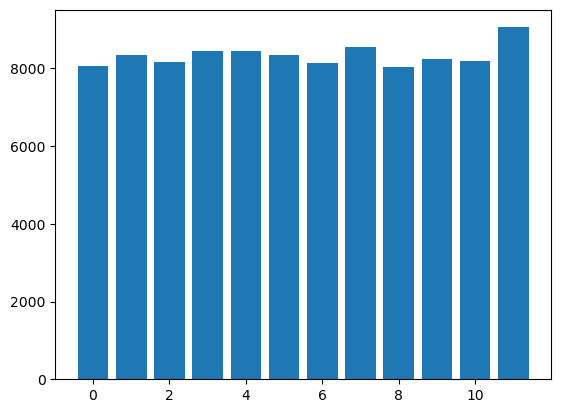

In [96]:
plt.bar(range(12), partition_distribution)
plt.show()

In [56]:
spark_session.stop()